## Prepare Notebook

In [455]:
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [456]:
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')

TnesorFlow version: 2.1.0
TnesorFlow Probability version: 0.9.0


## Distributions

In [457]:
normal = tfd.Normal(loc=0.0, scale=1.0)
gamma = tfd.Gamma(concentration=5.0, rate=1.0)
poisson = tfd.Poisson(rate=2.0)
laplace = tfd.Laplace(loc=0.0, scale=1.0)

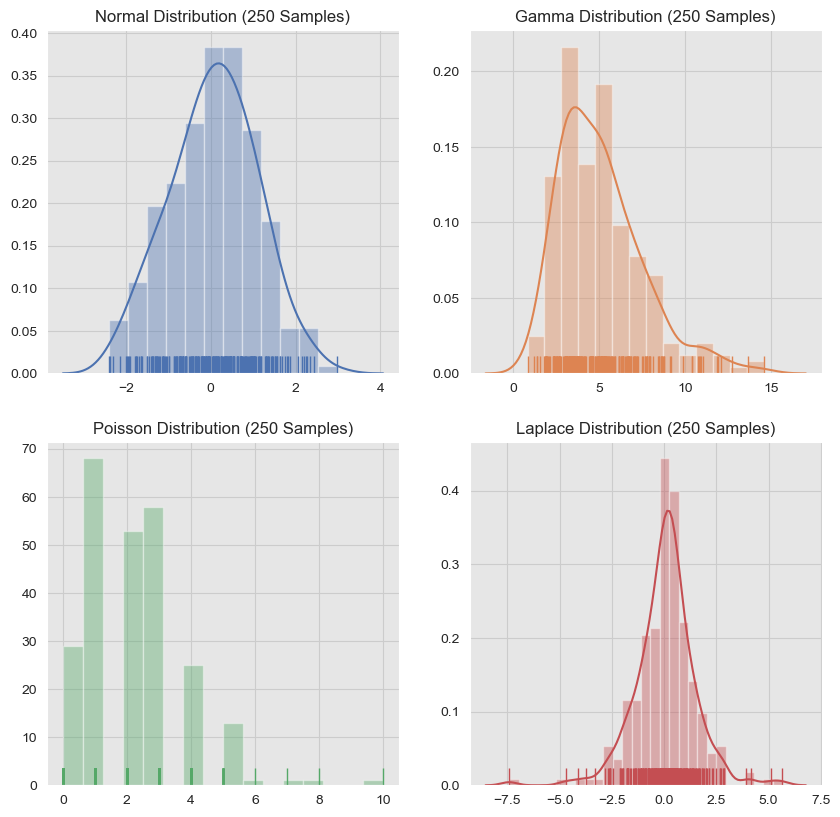

In [458]:
n_samples = 250

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

sns.distplot(a=normal.sample(n_samples), color=sns_c[0], rug=True, ax=axes[0])
axes[0].set(title=f'Normal Distribution ({n_samples} Samples)')

sns.distplot(a=gamma.sample(n_samples), color=sns_c[1], rug=True, ax=axes[1])
axes[1].set(title=f'Gamma Distribution ({n_samples} Samples)');

sns.distplot(a=poisson.sample(n_samples), color=sns_c[2], kde=False, rug=True, ax=axes[2])
axes[2].set(title=f'Poisson Distribution ({n_samples} Samples)');

sns.distplot(a=laplace.sample(n_samples), color=sns_c[3], rug=True, ax=axes[3])
axes[3].set(title=f'Laplace Distribution ({n_samples} Samples)');

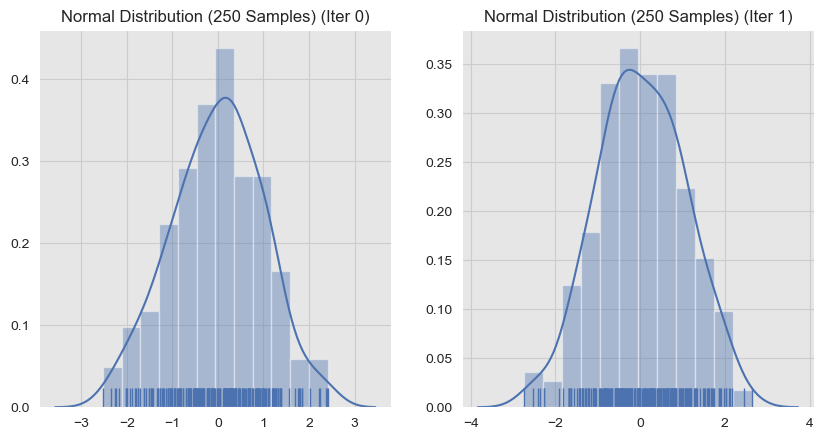

In [459]:
normal_samples = normal.sample([n_samples, n_samples])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes = axes.flatten()

for i in range(2):
    sns.distplot(a=normal_samples[i], color=sns_c[0], rug=True, ax=axes[i])
    axes[i].set(title=f'Normal Distribution ({n_samples} Samples) (Iter {i})')

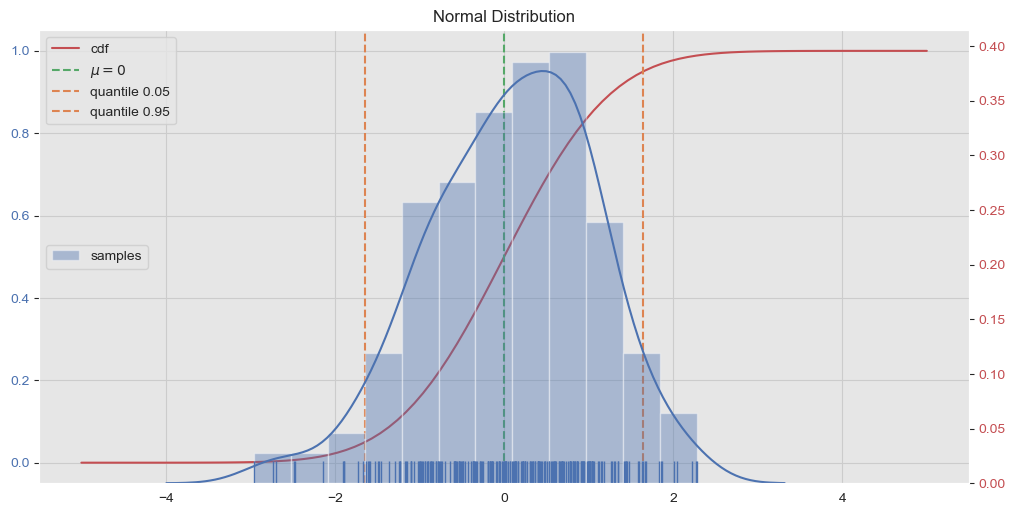

In [460]:
x = tf.linspace(start=-5.0, stop=5.0, num=100)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.lineplot(x=x, y=normal.cdf(x), color=sns_c[3], label='cdf', ax=ax1)
sns.distplot(a=normal.sample(n_samples), color=sns_c[0], label='samples', rug=True, ax=ax2)
ax1.axvline(x=0.0, color=sns_c[2], linestyle='--', label=r'$\mu=0$')

q_list = [0.05, 0.95]
quantiles = normal.quantile(q_list).numpy()
for i, q in zip(q_list , quantiles):
    ax1.axvline(x=q, color=sns_c[1], linestyle='--', label=f'quantile {i}')

ax1.tick_params(axis='y', labelcolor=sns_c[0])
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[3])
ax1.legend(loc='upper left')
ax2.legend(loc='center left')
ax1.set(title='Normal Distribution');

In [461]:
loc_list = np.linspace(start=0.0, stop=8.0, num=5)

normals = tfd.Normal(loc=loc_list, scale=1.0)

normal_samples = normals.sample(n_samples)

normal_samples.shape

TensorShape([250, 5])

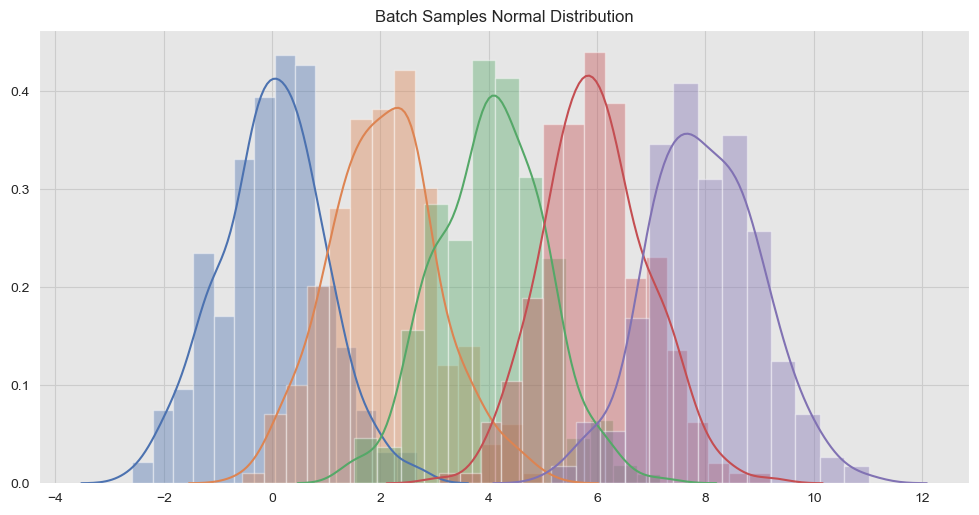

In [462]:
fig, ax = plt.subplots()

for i in range(normals.batch_shape[0]):
    sns.distplot(a=normal_samples[:, i], ax=ax)
ax.set(title='Batch Samples Normal Distribution');

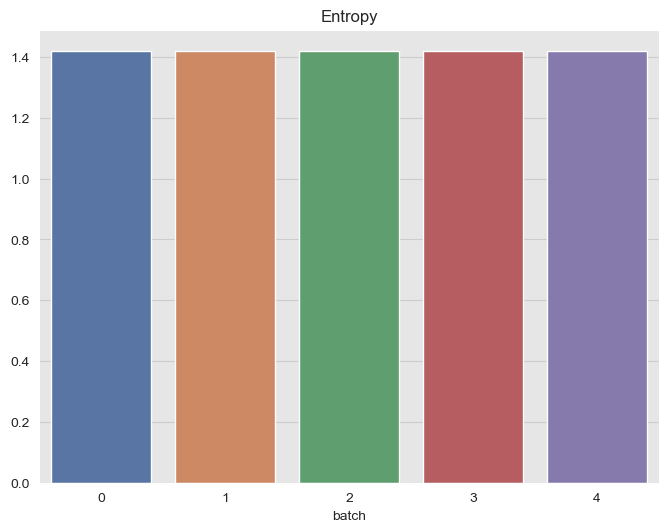

In [463]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=list(range(normals.batch_shape[0])), y=normals.entropy(), ax=ax)
ax.set(title='Entropy', xlabel='batch');

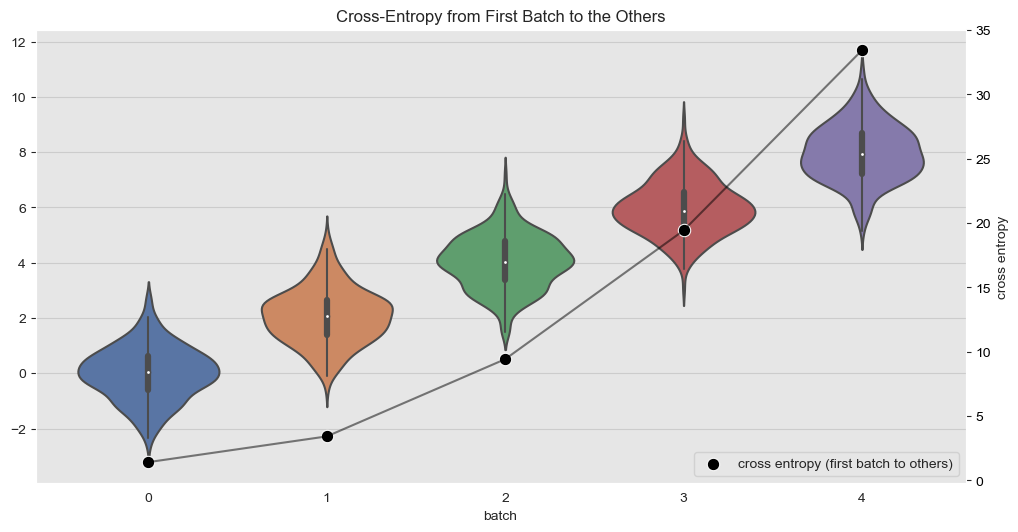

In [464]:
fig, ax1 = plt.subplots()

sns.violinplot(data=normal_samples, ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(x=range(normals.batch_shape[0]), y=normals[0].cross_entropy(normals), color='black',  alpha=0.5, ax=ax2)
sns.scatterplot(x=range(normals.batch_shape[0]), y=normals[0].cross_entropy(normals), s=80, color='black', label='cross entropy (first batch to others)', ax=ax2)

ax2.grid(None)
ax2.legend(loc='lower right')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set(ylabel='cross entropy')
ax1.set(title='Cross-Entropy from First Batch to the Others', xlabel='batch');

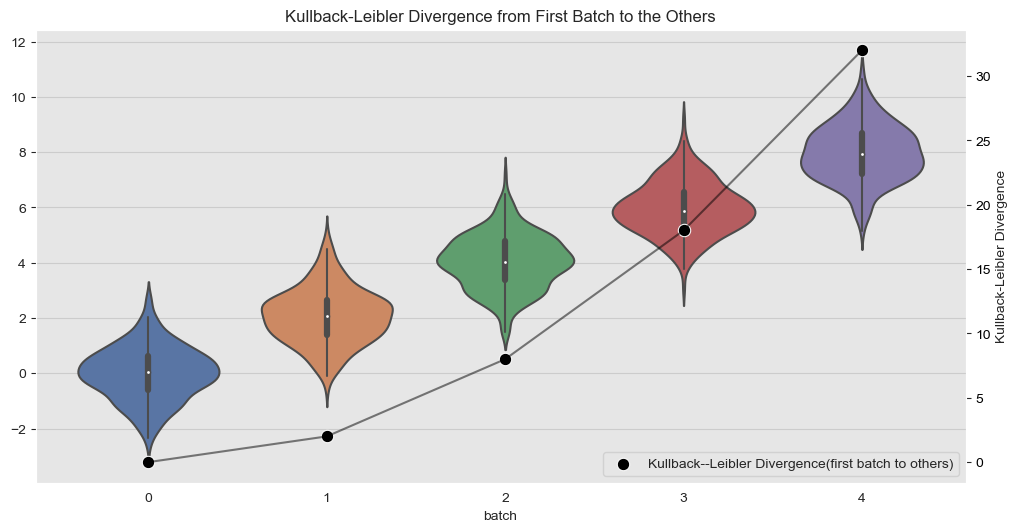

In [465]:
fig, ax1 = plt.subplots()

sns.violinplot(data=normal_samples, ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(x=range(normals.batch_shape[0]), y=normals[0].kl_divergence(normals), color='black',  alpha=0.5, ax=ax2)
sns.scatterplot(x=range(normals.batch_shape[0]), y=normals[0].kl_divergence(normals), s=80, color='black', label='Kullback--Leibler Divergence(first batch to others)', ax=ax2)

ax2.grid(None)
ax2.legend(loc='lower right')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set(ylabel='Kullback-Leibler Divergence')
ax1.set(title='Kullback-Leibler Divergence from First Batch to the Others', xlabel='batch');

In [466]:
mu = [1.0, 2.0]

cov = [[2.0, 1.0],
       [1.0, 1.0]]

cholesky = tf.linalg.cholesky(cov)

multi_normal = tfd.MultivariateNormalTriL(loc=mu, scale_tril=cholesky)

multi_normal_samples = multi_normal.sample(n_samples)

Text(0.5, 1.04, 'Multinormal Samples')

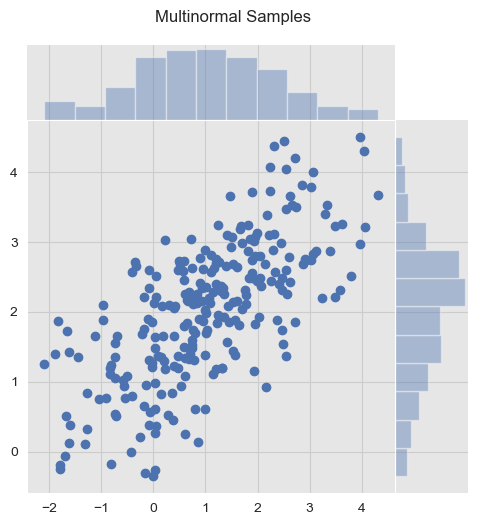

In [467]:
g = sns.jointplot(
    x=multi_normal_samples[:,0], 
    y=multi_normal_samples[:, 1], 
    space=0,
    height=5,
)

g.fig.suptitle('Multinormal Samples', y=1.04)

In [468]:
eq_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1.0, length_scale=1.0)
xs = tf.reshape(tf.linspace(0.0, 10.0, 200), [-1, 1])
gp_eq = tfd.GaussianProcess(kernel=eq_kernel, index_points=xs)

gp_eq_samples = gp_eq.sample(7)

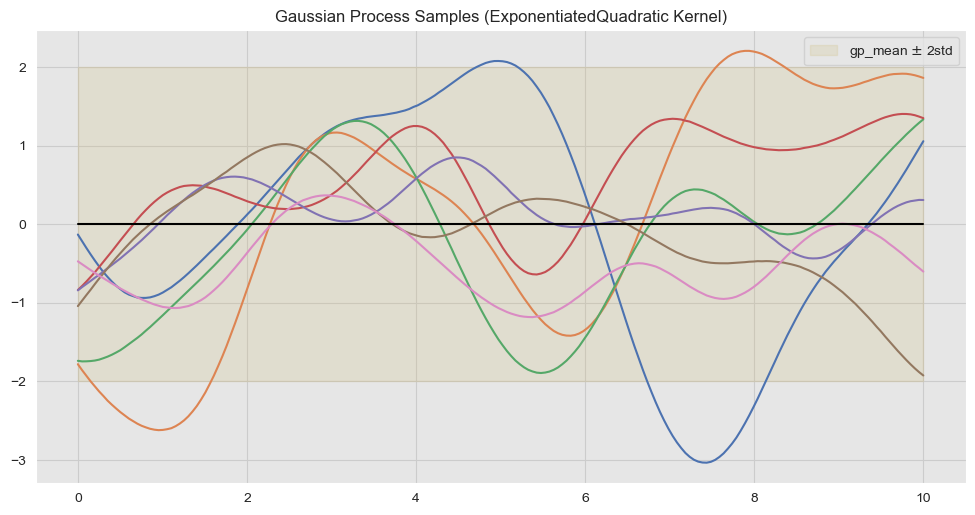

In [469]:
fig, ax = plt.subplots()

for i in range(7):
    sns.lineplot(x=xs[..., 0], y=gp_eq_samples[i, :], color=sns_c[i], ax=ax)

sns.lineplot(x=xs[..., 0], y=gp_eq.mean(), color='black', ax=ax)

upper, lower = gp_eq.mean() + [2 * gp_eq.stddev(), -2 * gp_eq.stddev()]
ax.fill_between(xs[..., 0], upper, lower, color=sns_c[8], alpha=0.2, label=r'gp_mean $\pm$ 2std')

ax.legend()
ax.set(title='Gaussian Process Samples (ExponentiatedQuadratic Kernel)');

In [470]:
es_kernel = tfp.math.psd_kernels.ExpSinSquared(amplitude=0.5, length_scale=1.5, period=3)
xs = tf.reshape(tf.linspace(0.0, 10.0, 200), [-1, 1])
gp_es = tfd.GaussianProcess(kernel=es_kernel, index_points=xs)

gp_es_samples = gp_es.sample(7)

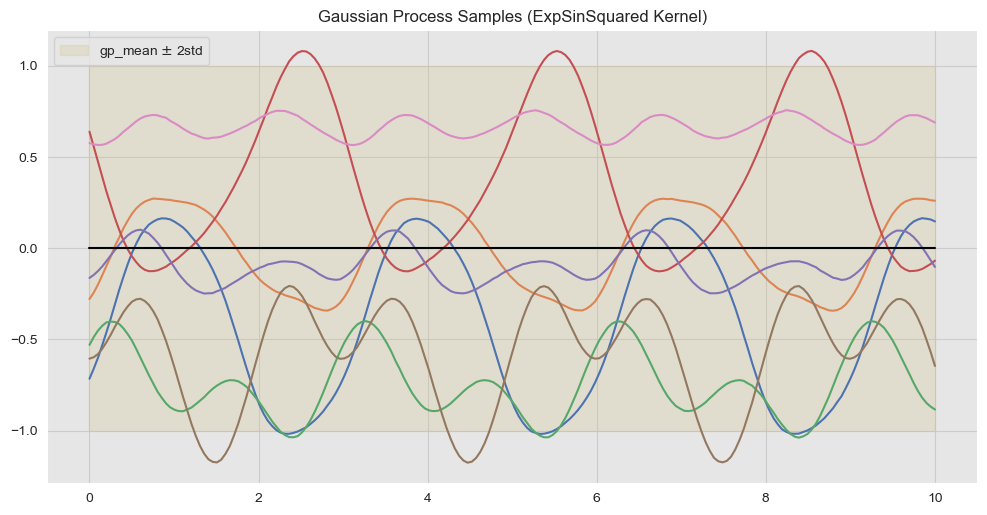

In [471]:
fig, ax = plt.subplots()

for i in range(7):
    sns.lineplot(x=xs[..., 0], y=gp_es_samples[i, :], color=sns_c[i], ax=ax)

sns.lineplot(x=xs[..., 0], y=gp_es.mean(), color='black', ax=ax)

upper, lower = gp_es.mean() + [2 * gp_es.stddev(), -2 * gp_es.stddev()]
ax.fill_between(xs[..., 0], upper, lower, color=sns_c[8], alpha=0.2, label=r'gp_mean $\pm$ 2std')

ax.legend()
ax.set(title='Gaussian Process Samples (ExpSinSquared Kernel)');

In [472]:
ys = tf.math.sin(1*np.pi*xs) + tf.math.sin(0.5*np.pi*xs)

In [473]:
n_obs = 20
indices = np.random.uniform(low=0.0, high=xs.shape[0], size=n_obs )
indices = [int(x) for x in np.round(indices)]


In [474]:
x_obs = tf.gather(params=xs, indices=indices)
y_obs = tf.gather(params=ys, indices=indices)
y_obs = y_obs[..., 0] + tf.random.normal(mean=0.0, stddev=0.05, shape=(n_obs, ))

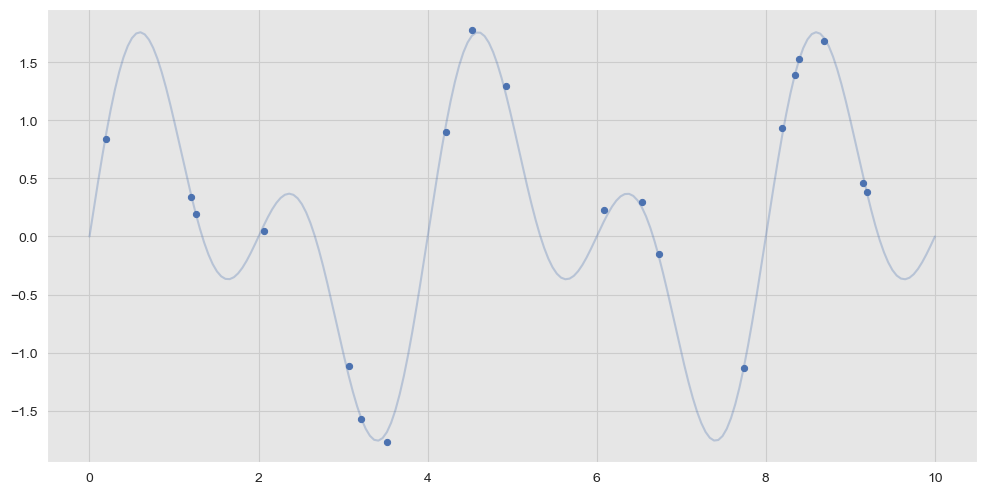

In [475]:
fig, ax = plt.subplots()

sns.lineplot(x=xs[..., 0], y=ys[..., 0], color=sns_c[0], alpha=0.3, ax=ax)
sns.scatterplot(x=x_obs[..., 0], y=y_obs, color=sns_c[0], s=20, edgecolor=sns_c[0], ax=ax)

In [476]:
kernel = tfp.math.psd_kernels.ExpSinSquared(amplitude=0.5, length_scale=1.0, period=4)
gprm = tfd.GaussianProcessRegressionModel(kernel=kernel, index_points=xs, observation_index_points=x_obs, observations=y_obs, observation_noise_variance=0.001)

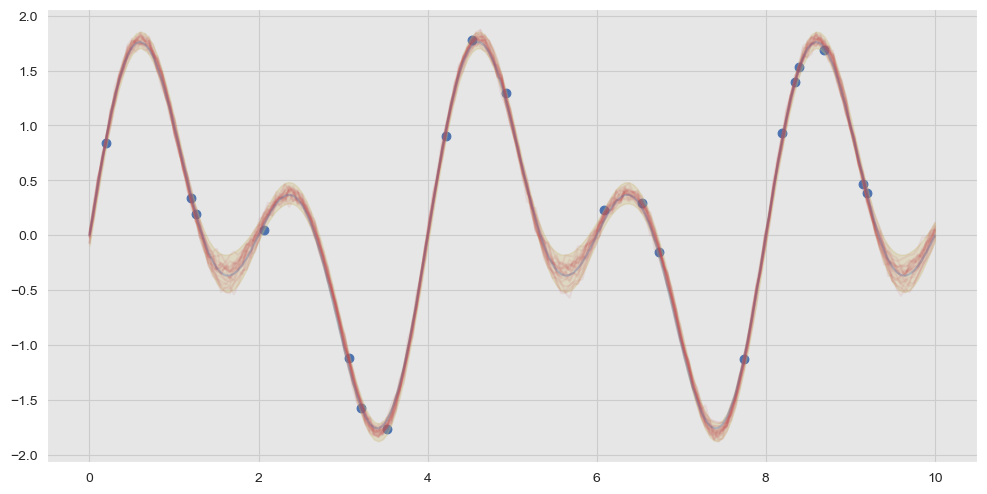

In [477]:
fig, ax = plt.subplots()

for _ in range(20):
    sns.lineplot(x=xs[..., 0], y=gprm.sample(), c=sns_c[3], alpha=0.1, ax=ax)

upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]

sns.lineplot(x=xs[..., 0], y=ys[..., 0], color=sns_c[0], alpha=0.3, ax=ax)
sns.scatterplot(x=x_obs[..., 0], y=y_obs, color=sns_c[0], s=40, edgecolor=sns_c[0], ax=ax)

ax.fill_between(xs[..., 0], upper, lower, color=sns_c[8], alpha=0.3, label=r'gp_mean $\pm$ 2std')